<a href="https://colab.research.google.com/github/sayakpaul/Multimodal-Entailment-Baseline/blob/main/text_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build a model for predicting textual entailment. Given two pieces of text the model should be able to predict if they contradict/entail/do not entail.

## Setup and imports

In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.3 MB 13.4 MB/s 


In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## Read dataset

In [3]:
train_df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/train_df.csv")
test_df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/test_df.csv")
val_df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/val_df.csv")
print(f"Training examples: {len(train_df)}")
print(f"Validation examples: {len(val_df)}")
print(f"Test examples: {len(test_df)}")

Training examples: 1197
Validation examples: 63
Test examples: 140


In [4]:
train_df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label,image_1_path,image_2_path,label_idx
1053,1361145825909473282,A Flood advisory has been issued in the FOX8 v...,http://pbs.twimg.com/media/EuPC6lKXcAIl6Uu.png,1381033827410325507,A Flood advisory has been issued in the FOX8 v...,http://pbs.twimg.com/media/Eypq73iXMAMMpKb.jpg,NoEntailment,tweet_images/1361145825909473282.png,tweet_images/1381033827410325507.jpg,2
1042,1363167912341733386,#onweather\n\nWINTER WEATHER TRAVEL ADVISORY C...,http://pbs.twimg.com/media/Eurx_eMXIAMyOjp.jpg,1363167916947099650,#onweather\n\nWINTER WEATHER TRAVEL ADVISORY E...,http://pbs.twimg.com/media/Eurx_wDXMAExhIT.jpg,Implies,tweet_images/1363167912341733386.jpg,tweet_images/1363167916947099650.jpg,1
683,1377904670887141377,"Life is a maybe, Death is for sure. Sin is the...",http://pbs.twimg.com/media/Ex9AeNUVEAQP5Lx.jpg,1378068662821683200,Bless everyone in these trying times. Let's al...,http://pbs.twimg.com/media/Ex_iJVhVoAAQc19.jpg,NoEntailment,tweet_images/1377904670887141377.jpg,tweet_images/1378068662821683200.jpg,2
1184,1356719777159471106,"The bottom three on form are Birmingham, Rothe...",http://pbs.twimg.com/media/EtQJThBXEAMSKom.jpg,1383323542373031937,The 12-game form table. Preston North End are ...,http://pbs.twimg.com/media/EzKNa5NVIAATfMZ.jpg,NoEntailment,tweet_images/1356719777159471106.jpg,tweet_images/1383323542373031937.jpg,2
1142,1377794214629494786,Check out this item I just got! [Duskwarder Wa...,http://pbs.twimg.com/media/Ex7oiYkU4AE66y8.jpg,1380320402942029829,Check out this item I just got! [Gorewrought M...,http://pbs.twimg.com/media/EyfiF6oU8AEGzhJ.jpg,NoEntailment,tweet_images/1377794214629494786.jpg,tweet_images/1380320402942029829.jpg,2
340,1335817457018286080,Nokia 5.4 full specifications leak online ahea...,http://pbs.twimg.com/media/EonG2ybWEAEOjfo.png,1335819879350321153,Nokia 5.4 full specifications leak online ahea...,http://pbs.twimg.com/media/EonJGCNUYAAMdRC.jpg,NoEntailment,tweet_images/1335817457018286080.png,tweet_images/1335819879350321153.jpg,2
551,1368995843697602561,Monday Member Moments! Let American United cat...,http://pbs.twimg.com/media/Ev-mWSBUUAA4Y9_.jpg,1379091960112185344,Monday Member Moments! Want it your way? Let A...,http://pbs.twimg.com/media/EyEIlr9UUAQkEDl.jpg,NoEntailment,tweet_images/1368995843697602561.jpg,tweet_images/1379091960112185344.jpg,2
979,1374087053189771268,Check out this week's Wolves Week! https://t.c...,http://pbs.twimg.com/media/ExG85H8WgAYOpxe.jpg,1376960406586032133,Here is this week's Wolves Week https://t.co/F...,http://pbs.twimg.com/media/ExvyMWFXMAEZaAq.jpg,NoEntailment,tweet_images/1374087053189771268.jpg,tweet_images/1376960406586032133.jpg,2
983,1373776004175560711,tocache : 📢 Printing is at 40% https://t.co/QB...,http://pbs.twimg.com/media/ExCh_glW8AAmteL.png,1383466314312740869,tocache : 📢 Printing is at 70% https://t.co/X3...,http://pbs.twimg.com/media/EzMPRtMUUAIxRJc.png,NoEntailment,tweet_images/1373776004175560711.png,tweet_images/1383466314312740869.png,2
64,1376951543128326150,The Bluejay baseball team (2-2) lost to a good...,http://pbs.twimg.com/media/ExvqIY6XAAE9VMS.jpg,1382863178921574402,Bluejays move to 9-4 with a 9-7 win over St. P...,http://pbs.twimg.com/media/EzDqu4kXMAAhCuu.jpg,NoEntailment,tweet_images/1376951543128326150.jpg,tweet_images/1382863178921574402.jpg,2


## Data input pipeline

In [5]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [6]:
# Reference:
# https://www.tensorflow.org/text/tutorials/bert_glue

def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)

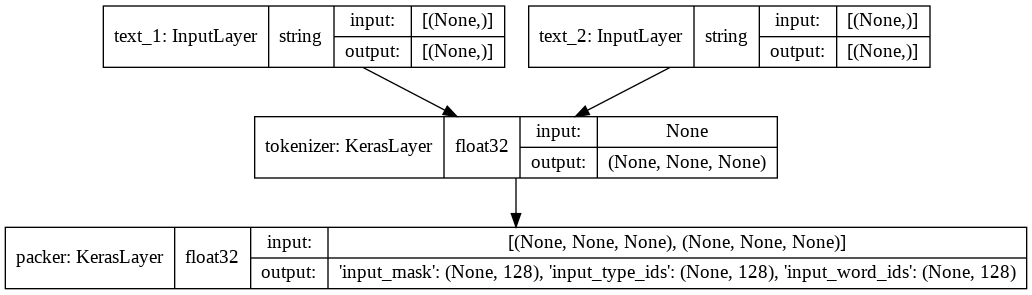

In [7]:
bert_preprocess_model = make_bert_preprocess_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

In [8]:
def dataframe_to_dataset(dataframe):
    columns = ["text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    return ds

In [9]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_dataset(df, training=True):
    ds = dataframe_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x: (bert_preprocess_model(x), x["label_idx"]))
    ds = ds.cache().prefetch(auto)
    return ds

train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['label_idx'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [10]:
# Separate the train and test labels for later evaluation.
def separate_labels(ds):
    labels = []
    for _, label in ds.unbatch():
        labels.append(label)
    labels = np.array(labels)
    return labels

train_labels = separate_labels(train_ds)
test_labels = separate_labels(test_ds)

## Model utilities

In [11]:
# Reference:
# https://www.tensorflow.org/text/tutorials/bert_glue
def build_classifier_model(num_classes=3):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(bert_model_path, trainable=False)
      self.dropout = keras.layers.Dropout(0.1)
      self.dense = keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

## Compile and train the model

In [12]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history = classifier_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
38/38 [==============================] - 5s 27ms/step - loss: 3.4904 - accuracy: 0.3826 - val_loss: 1.0986 - val_accuracy: 0.7302
Epoch 2/10
38/38 [==============================] - 1s 16ms/step - loss: 1.1026 - accuracy: 0.5505 - val_loss: 1.0986 - val_accuracy: 0.7619
Epoch 3/10
38/38 [==============================] - 1s 18ms/step - loss: 1.1156 - accuracy: 0.5973 - val_loss: 1.0986 - val_accuracy: 0.6984
Epoch 4/10
38/38 [==============================] - 1s 16ms/step - loss: 1.0977 - accuracy: 0.5096 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 5/10
38/38 [==============================] - 1s 28ms/step - loss: 1.1095 - accuracy: 0.5171 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 1.0977 - accuracy: 0.5530 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 7/10
38/38 [==============================] - 1s 18ms/step - loss: 1.0977 - accuracy: 0.5530 - val_loss: 1.0986 - val_accuracy: 0.6667
Epoch 8/10
38

## Model evaluation

In [13]:
_, acc = classifier_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 1s 7ms/step - loss: 1.0986 - accuracy: 0.6714
Accuracy on the test set: 67.14%.


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ["Contradictory", "Implies", "NoEntailment"]

def detailed_test_eval(model):
    prediction_labels = np.argmax(model.predict(test_ds), 1)
    print(classification_report(test_labels, prediction_labels, target_names=class_names))
    return pd.DataFrame(confusion_matrix(test_labels, prediction_labels),
                        index=class_names, columns=class_names)

In [15]:
detailed_test_eval(classifier_model)

               precision    recall  f1-score   support

Contradictory       0.11      0.18      0.13        11
      Implies       0.00      0.00      0.00        11
 NoEntailment       0.84      0.78      0.81       118

     accuracy                           0.67       140
    macro avg       0.32      0.32      0.31       140
 weighted avg       0.72      0.67      0.69       140



,Contradictory,Implies,NoEntailment
Contradictory,2,0,9
Implies,3,0,8
NoEntailment,14,12,92


## Loss weighted training 

In [16]:
# Reference: https://bit.ly/3xxtgSy

train_labels_ohe = keras.utils.to_categorical(train_labels)
class_totals = train_labels_ohe.sum(axis=0)
class_weight = dict()

for i in range(0, len(class_totals)):
	class_weight[i] = class_totals.max() / class_totals[i]

class_weight

{0: 10.870968, 1: 10.870968, 2: 1.0}

In [17]:
classifier_model_lw = build_classifier_model()
classifier_model_lw.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)
history = classifier_model_lw.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/10
38/38 [==============================] - 3s 20ms/step - loss: 16.1257 - accuracy: 0.0785 - val_loss: 14.4449 - val_accuracy: 0.0794
Epoch 2/10
38/38 [==============================] - 1s 17ms/step - loss: 15.4939 - accuracy: 0.0819 - val_loss: 14.2637 - val_accuracy: 0.0794
Epoch 3/10
38/38 [==============================] - 1s 17ms/step - loss: 15.3656 - accuracy: 0.0869 - val_loss: 14.2601 - val_accuracy: 0.0635
Epoch 4/10
38/38 [==============================] - 1s 15ms/step - loss: 15.5883 - accuracy: 0.0877 - val_loss: 14.3683 - val_accuracy: 0.0635
Epoch 5/10
38/38 [==============================] - 1s 30ms/step - loss: 15.7216 - accuracy: 0.0852 - val_loss: 14.2667 - val_accuracy: 0.0476
Epoch 6/10
38/38 [==============================] - 1s 22ms/step - loss: 15.3493 - accuracy: 0.0877 - val_loss: 14.2710 - val_accuracy: 0.0635
Epoch 7/10
38/38 [==============================] - 1s 20ms/step - loss: 15.3074 - accuracy: 0.0894 - val_loss: 14.4062 - val_accuracy: 0.0794

In [18]:
_, acc = classifier_model_lw.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 0s 6ms/step - loss: 14.2721 - accuracy: 0.1143
Accuracy on the test set: 11.43%.


In [19]:
detailed_test_eval(classifier_model_lw)

               precision    recall  f1-score   support

Contradictory       0.14      0.64      0.23        11
      Implies       0.10      0.82      0.18        11
 NoEntailment       0.00      0.00      0.00       118

     accuracy                           0.11       140
    macro avg       0.08      0.48      0.14       140
 weighted avg       0.02      0.11      0.03       140



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Contradictory,Implies,NoEntailment
Contradictory,7,4,0
Implies,2,9,0
NoEntailment,41,77,0


## Focal loss

In [20]:
!pip install -q focal-loss

In [21]:
from focal_loss import SparseCategoricalFocalLoss

In [22]:
classifier_model_focal = build_classifier_model()
classifier_model_focal.compile(
    optimizer="adam", loss=SparseCategoricalFocalLoss(gamma=2), metrics="accuracy"
)
history = classifier_model_focal.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
38/38 [==============================] - 3s 17ms/step - loss: 4.2763 - accuracy: 0.6466 - val_loss: 0.1948 - val_accuracy: 0.6825
Epoch 2/10
38/38 [==============================] - 1s 16ms/step - loss: 0.5011 - accuracy: 0.4595 - val_loss: 0.5090 - val_accuracy: 0.6667
Epoch 3/10
38/38 [==============================] - 1s 15ms/step - loss: 0.5643 - accuracy: 0.5455 - val_loss: 0.1164 - val_accuracy: 0.5556
Epoch 4/10
38/38 [==============================] - 1s 27ms/step - loss: 0.3243 - accuracy: 0.3885 - val_loss: 0.0972 - val_accuracy: 0.5397
Epoch 5/10
38/38 [==============================] - 1s 23ms/step - loss: 0.3478 - accuracy: 0.4411 - val_loss: 0.0848 - val_accuracy: 0.3968
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.2991 - accuracy: 0.3743 - val_loss: 0.0652 - val_accuracy: 0.5079
Epoch 7/10
38/38 [==============================] - 1s 30ms/step - loss: 0.2792 - accuracy: 0.4344 - val_loss: 0.0687 - val_accuracy: 0.5714
Epoch 8/10
38

In [23]:
_, acc = classifier_model_focal.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 0s 6ms/step - loss: 0.0634 - accuracy: 0.3786
Accuracy on the test set: 37.86%.


In [24]:
detailed_test_eval(classifier_model_focal)

               precision    recall  f1-score   support

Contradictory       0.15      0.73      0.25        11
      Implies       0.09      0.36      0.15        11
 NoEntailment       0.91      0.35      0.50       118

     accuracy                           0.38       140
    macro avg       0.39      0.48      0.30       140
 weighted avg       0.79      0.38      0.46       140



,Contradictory,Implies,NoEntailment
Contradictory,8,1,2
Implies,5,4,2
NoEntailment,39,38,41
